# Rogue Photon Analysis

This is an analysis to investigate the effect of photons being scattered at "weird" angles inside the optical module and thereby have a large angular distance between where they touch the glass and where they are detected. This could influence the reconstruction quality with regards to the angular resolution.

By the end we want to understand:
- how those "rogue photons" behave i.e. if there is some specific path they take / get scattered of some specific surface.
- what percentage of photons show regular (nice) behavior and what percentage does not.
- how much those photons influence the angular resolution i.e. as a first step, how far does the glass contact point from those photons lie from their detection point.

### imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

### settings and data preparation

First, the PMT positions on the unit sphere have to be fixed. The numbering corresponds to the PMT copy nr from the Geant4 Simulation. The width of the flange has been neglected.


In [2]:
# PMT position dict containing the angles for each PMT
pmt_positions = {
    0:  (     0,     25),
    1:  (    90,     25),
    2:  (   180,     25),
    3:  ( -  90,     25),
    4:  (    45,   57.5),
    5:  (   135,   57.5),
    6:  ( - 135,   57.5),
    7:  ( -  45,   57.5),
    8:  (    90, -   25),
    9:  (     0, -   25),
    10: ( -  90, -   25),
    11: (   180, -   25),
    12: (    45, - 57.5),
    13: ( -  45, - 57.5),
    14: ( - 135, - 57.5),
    15: (   135, - 57.5),
}

The datafile comes out of the Geant4 Simulation and should be from homogenous illumination of the P-OM. Ideally it is pre-filtered on photons that are absorbed in the photocathodes to reduce memory. However, we will filter for that anyways.

In [3]:
datafile = "/home/nretza/ECP_libraries/Geant4-Simulations/P-OM/data/out_photons_open_frame.csv"

df = pd.read_csv(datafile)
df = df.query("PID == -22 and g_x != 0 and g_y != 0 and g_z != 0 and out_ProcessName == 'OpAbsorption' and out_VolumeName.str.contains('photocathode')")

we need to subtract the width of the flange for the later analysis

In [4]:
flange_thickness = 90 # mm
df['g_z'] = df['g_z'] - flange_thickness/2 * np.sign(df["g_z"])

### first plots on full data

We want to create a 2D projection of the glass contact points. Each point should be colored with respect to the PMT it was detected in. We overlay that by the PMT-positions in the corresponding color. To do this for a given dataset, we define the following function:

In [5]:
def plot_sphere_projection(df):

    # transform glass contact points to polar coordinates
    photons_g_r     = np.sqrt(df['g_x']**2 + df['g_y']**2 + (df['g_z'])**2)
    photons_g_theta = np.pi/2 - np.arccos((df['g_z'])/photons_g_r)
    photons_g_phi   = np.arctan2(df['g_y'], df['g_x'])

    # histogram to keep track of PMT hits
    pmt_hits, pmt_hit_bins = np.histogram(df['out_Volume_CopyNo'], bins=range(len(pmt_positions) + 1))

    # plot settings
    dpi        = 300
    font_size  = 6
    s_min      = 50
    s_max      = 500
    alpha      = 0.5

    plt.rcParams['figure.dpi']  = dpi
    plt.rcParams['savefig.dpi'] = dpi

    plt.figure()
    plt.subplot(projection="mollweide")
    plt.grid(True)
    plt.xlabel("phi", fontsize = font_size)
    plt.ylabel("theta", fontsize = font_size)
    plt.xticks(fontsize=font_size) 
    plt.yticks(fontsize=font_size)

    # pmt colors
    pmt_colors = plt.cm.tab20(np.linspace(0, 1, 16))

    # scatter plot for glass contact points
    plt.scatter(photons_g_phi, photons_g_theta, s=0.2, c=pmt_colors[df['out_Volume_CopyNo']], cmap='viridis')

    # Plot circles for each PMT
    for i, pos in pmt_positions.items():
        x = np.deg2rad(pos[0])
        y = np.deg2rad(pos[1])
        size = (s_max - s_min) * pmt_hits[i] / max(pmt_hits) + s_min
        color = pmt_colors[i]
        plt.scatter(x, y, s=size, color=color, alpha=alpha)
        plt.annotate(f"{pmt_hits[i]}", xy=(x, y), ha='center', va='center', size=font_size)
        if x == np.pi:
            plt.scatter(-np.pi, y, s=size, color=color, alpha=alpha)
            plt.annotate(f"{pmt_hits[i]}", xy=(-np.pi, y), ha='center', va='center', size=font_size)

Let's execute that for the full dataset:

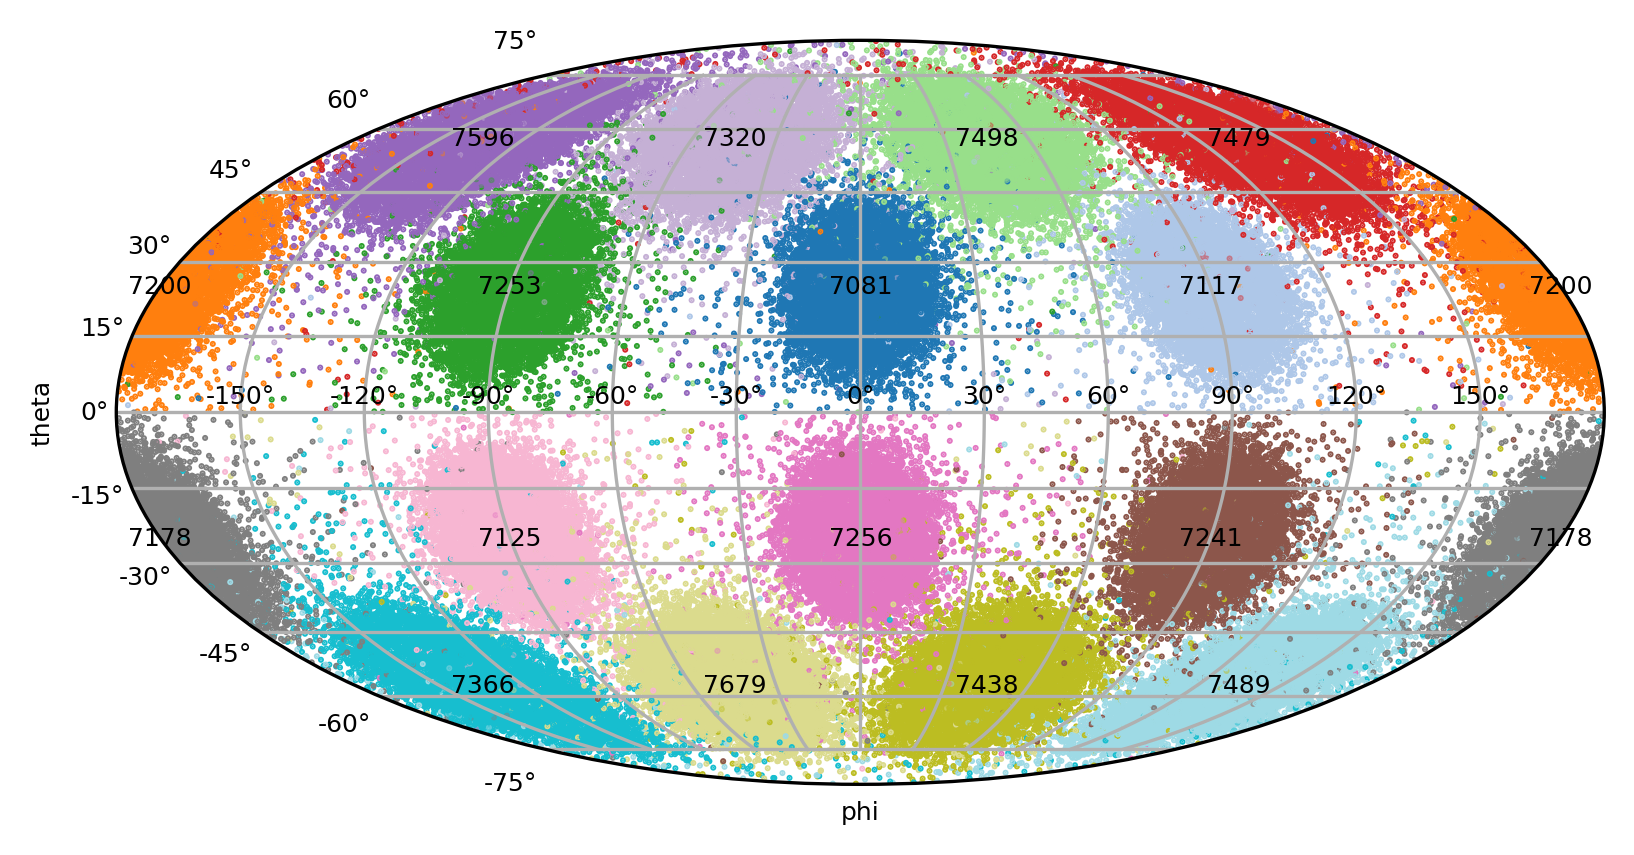

In [6]:
plot_sphere_projection(df)

Now that we have a first visual image we want to see how far those glass contact points deviate on average from the PMT positions. We therefore calculate the angular distance between the glass contact points and and the position of the PMT the photon was detected in. Because we can naively suspect that photons that show "bad" behavior, meaning a higher angular distance than the average distance between PMTs, hit the glass at high inclinations, we additionally calculate the angle at which the photon hits the glass.

Everything can then be put into a 2D histogram:

In [7]:
def angluar_distance_to_inclination_angle_hist(df):
    
    # transform glass contact points to polar coordinates
    photons_g_r     = np.sqrt(df['g_x']**2 + df['g_y']**2 + (df['g_z'])**2)
    photons_g_theta = np.pi/2 - np.arccos((df['g_z'])/photons_g_r)
    photons_g_phi   = np.arctan2(df['g_y'], df['g_x'])
    photon_g_angles = np.array([photons_g_phi, photons_g_theta]).T

    # Calculate the angular distance between glass contact point and detection pmt position
    pmt_positions_for_photons  = np.take(np.deg2rad(list(pmt_positions.values())), df['out_Volume_CopyNo'], axis=0)
    angular_distances_g_to_pmt = np.arccos( np.sin(photon_g_angles[:,1]) * np.sin(pmt_positions_for_photons[:,1])
                                          + np.cos(photon_g_angles[:,1]) * np.cos(pmt_positions_for_photons[:,1])
                                          * np.cos(photon_g_angles[:,0]  - pmt_positions_for_photons[:,0]))

    # Calculate the angle between photon momentum and position (normal vector to glass).
    photon_g_position = np.array([df['g_x'], df['g_y'], df['g_z']]).T
    photon_g_momentum = np.array([df['g_px'], df['g_py'], df['g_pz']]).T
    angle_g_pos_mom   = np.arccos(np.clip(np.sum( - photon_g_position * photon_g_momentum, axis=1)/(np.linalg.norm(photon_g_position, axis=1) * np.linalg.norm(photon_g_momentum, axis=1)), -1.0, 1.0))

    # # plot everything
    dpi        = 200
    font_size  = 6
    x_lim      = 90
    y_lim      = 85

    plt.rcParams['figure.dpi']  = dpi
    plt.rcParams['savefig.dpi'] = dpi

    plt.hist2d(np.rad2deg(angular_distances_g_to_pmt), np.rad2deg(angle_g_pos_mom), bins=500)
    plt.xlabel("angular distance from photon-glass-contact-point to center of PMT [°]", fontsize = font_size)
    plt.ylabel("angle between photon direction at glass contact point and glass normal vector [°]", fontsize = font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.xlim(0, x_lim)
    plt.ylim(0, y_lim)

And lets execute that:

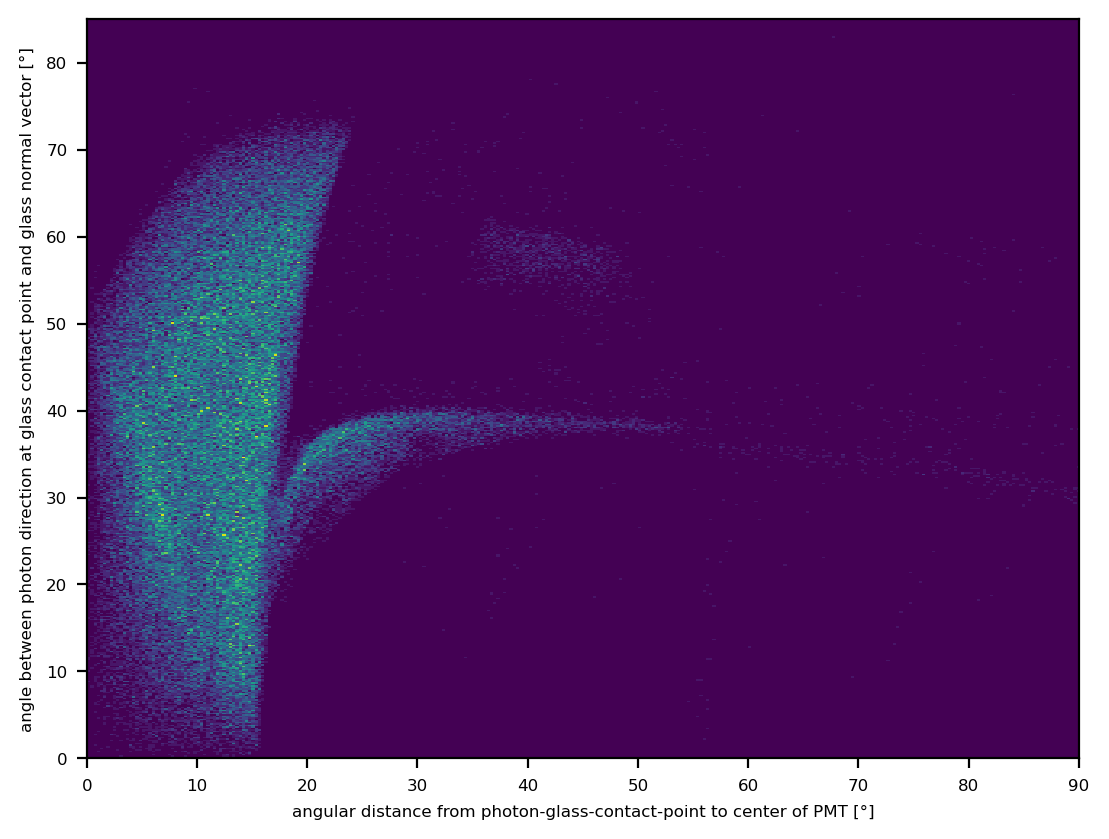

In [8]:
angluar_distance_to_inclination_angle_hist(df)

Interesting! We see multiple clusters in this plot:
- a banana shape left of x = 20°. This can be identified as nicely behaving photons.
- (a)   a spread out cluster left of x = 20° and with y between 30° and 40°
- (b) another cluster between 30° and 50° in x and 50° to 65° in y
- (c)   more or less random noise beyond x = 55°

### data clustering

lets filter for those clusters:

In [9]:
# transform glass contact points to polar coordinates
photons_g_r     = np.sqrt(df['g_x']**2 + df['g_y']**2 + (df['g_z'])**2)
photons_g_theta = np.pi/2 - np.arccos((df['g_z'])/photons_g_r)
photons_g_phi   = np.arctan2(df['g_y'], df['g_x'])

# Calculate the angular distance between glass contact point and detection pmt position
photon_g_angles            = np.array([photons_g_phi, photons_g_theta]).T
pmt_positions_for_photons  = np.take(np.deg2rad(list(pmt_positions.values())), df['out_Volume_CopyNo'], axis=0)
angular_distances_g_to_pmt = np.arccos(  np.sin(photon_g_angles[:,1]) * np.sin(pmt_positions_for_photons[:,1])
                                    + np.cos(photon_g_angles[:,1]) * np.cos(pmt_positions_for_photons[:,1])
                                    * np.cos(photon_g_angles[:,0] -pmt_positions_for_photons[:,0]))

# Calculate the angle between photon momentum and position (normal vector to glass).
photon_g_position = - np.array([df['g_x'], df['g_y'], df['g_z']]).T
photon_g_momentum = np.array([df['g_px'], df['g_py'], df['g_pz']]).T
angle_g_pos_mom   = np.arccos(np.clip(np.sum(photon_g_position * photon_g_momentum, axis=1)/(np.linalg.norm(photon_g_position, axis=1) * np.linalg.norm(photon_g_momentum, axis=1)), -1.0, 1.0))

# create new datasets by filtering
df_a = df[(angular_distances_g_to_pmt > np.deg2rad(17)) & (angular_distances_g_to_pmt < np.deg2rad(55)) & (angle_g_pos_mom > np.deg2rad(30)) & (angle_g_pos_mom < np.deg2rad(40))]
df_b = df[(angular_distances_g_to_pmt > np.deg2rad(30)) & (angular_distances_g_to_pmt < np.deg2rad(50)) & (angle_g_pos_mom > np.deg2rad(50)) & (angle_g_pos_mom < np.deg2rad(65))]
df_c = df[(angular_distances_g_to_pmt > np.deg2rad(55))]

we also want to recreate the events in those clusters. we thereby create a Geant4 macro that recreates the initial conditions of a subsample of those clusters:

In [10]:
def event_recreation(df, samples=5, runs_per_sample=5):
    
    df_random = df.sample(samples)
    print(df_random[['in_E','in_x', 'in_y', 'in_z', 'in_px', 'in_py', 'in_pz']])

    with open('/home/nretza/ECP_libraries/Geant4-Simulations/P-OM/analysis/rogue_photons/output_file.txt', 'w') as f:
        f.write("/vis/viewer/flush\n")
        f.write("/vis/scene/endOfEventAction accumulate\n")
        f.write("/vis/scene/endOfRunAction accumulate\n")
        f.write("/vis/scene/add/trajectories\n")
        for row in df_random.itertuples():
            f.write("\n")
            f.write("/gps/ene/type Mono\n")
            f.write(f"/gps/ene/mono {row.in_E} eV\n")
            f.write(f"/gps/position {row.in_x} {row.in_y} {row.in_z} mm\n")
            f.write(f"/gps/direction {row.in_px} {row.in_py} {row.in_pz}\n")
            f.write(f"/run/beamOn {runs_per_sample}\n")

### cluster a:

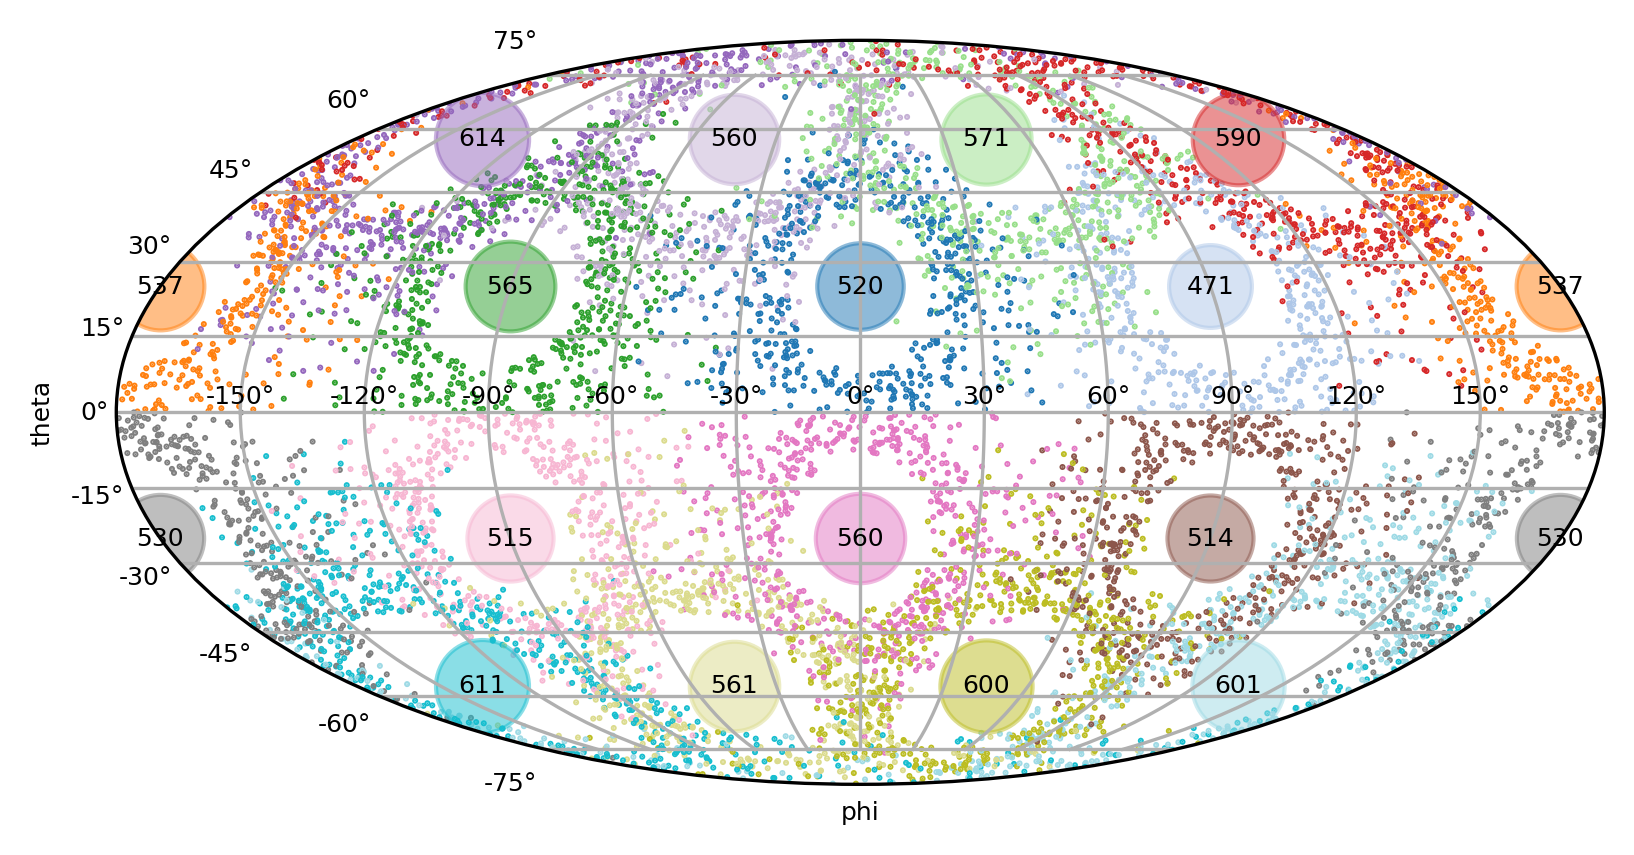

In [11]:
plot_sphere_projection(df_a)

The photons seem to touch the glass in a ring around the PMTs at a certain distance. This could be due to refraction between glass and air inside the module, which throws the photon on a trajectory towards the gelpad, which subsequently captures it in the PMT. 

In [12]:
event_recreation(df_a)

           in_E      in_x      in_y     in_z     in_px     in_py     in_pz
443288  3.14970  205.8630  156.0650 -152.525 -0.416395 -0.880785  0.225460
989246  2.22359  173.4630 -199.3080 -142.080 -0.905730  0.415992  0.081266
811713  3.41525  -87.2660   12.1836  286.769 -0.216227 -0.047716 -0.975176
325600  2.62783  -92.9398   21.3006 -284.444  0.790133  0.025330  0.612412
47622   3.06231 -123.8100  176.9080  208.266  0.757466 -0.626538 -0.183562


Visual confirmation of the recreated events in Geant4 confirms this:

In [13]:
images = ['a_1.png', 'a_2.png', 'a_3.png']
heights = [350, 350, 350]
html_str = ''
for img, height in zip(images, heights):
    html_str += f'<img src={img} height="{height}" />'
display(HTML(html_str))

### cluster b:

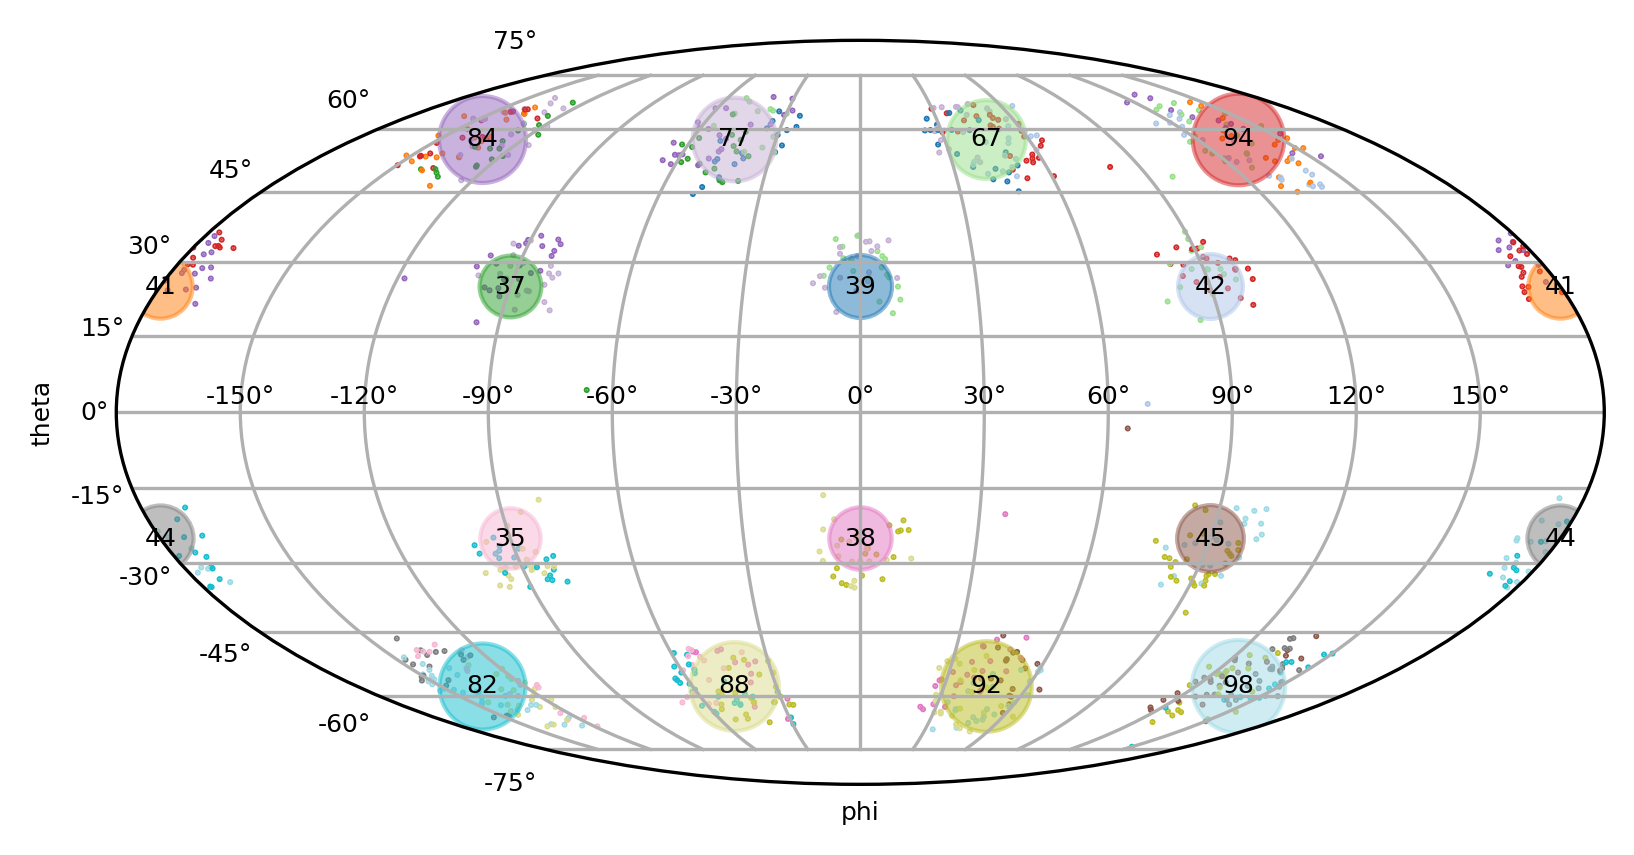

In [14]:
plot_sphere_projection(df_b)

The photons touch the glass at the position of other PMTs. Apparently they must be scattered in one gelpad and thrown inside another gelpad, where the PMT detects it.

In [15]:
event_recreation(df_b)

            in_E      in_x      in_y     in_z     in_px     in_py     in_pz
640075   2.85426  -92.2721   45.7959  281.760  0.566458  0.502801 -0.652930
822127   3.30870   36.4474 -278.3910 -105.688 -0.463217  0.809008 -0.361850
1532301  3.66884 -257.7690   74.3978 -134.239  0.855655 -0.432348 -0.284481
128972   3.32861  -15.1158   86.0755 -286.989 -0.476751 -0.751496  0.456029
1277487  3.22907 -124.5420   59.7628 -266.304  0.463935  0.529451  0.710243


Geant4 confirms this:

In [16]:
images = ['b_1.png', 'b_2.png']
heights = [350, 350]
html_str = ''
for img, height in zip(images, heights):
    html_str += f'<img src={img} height="{height}" />'
display(HTML(html_str))

### cluster c:

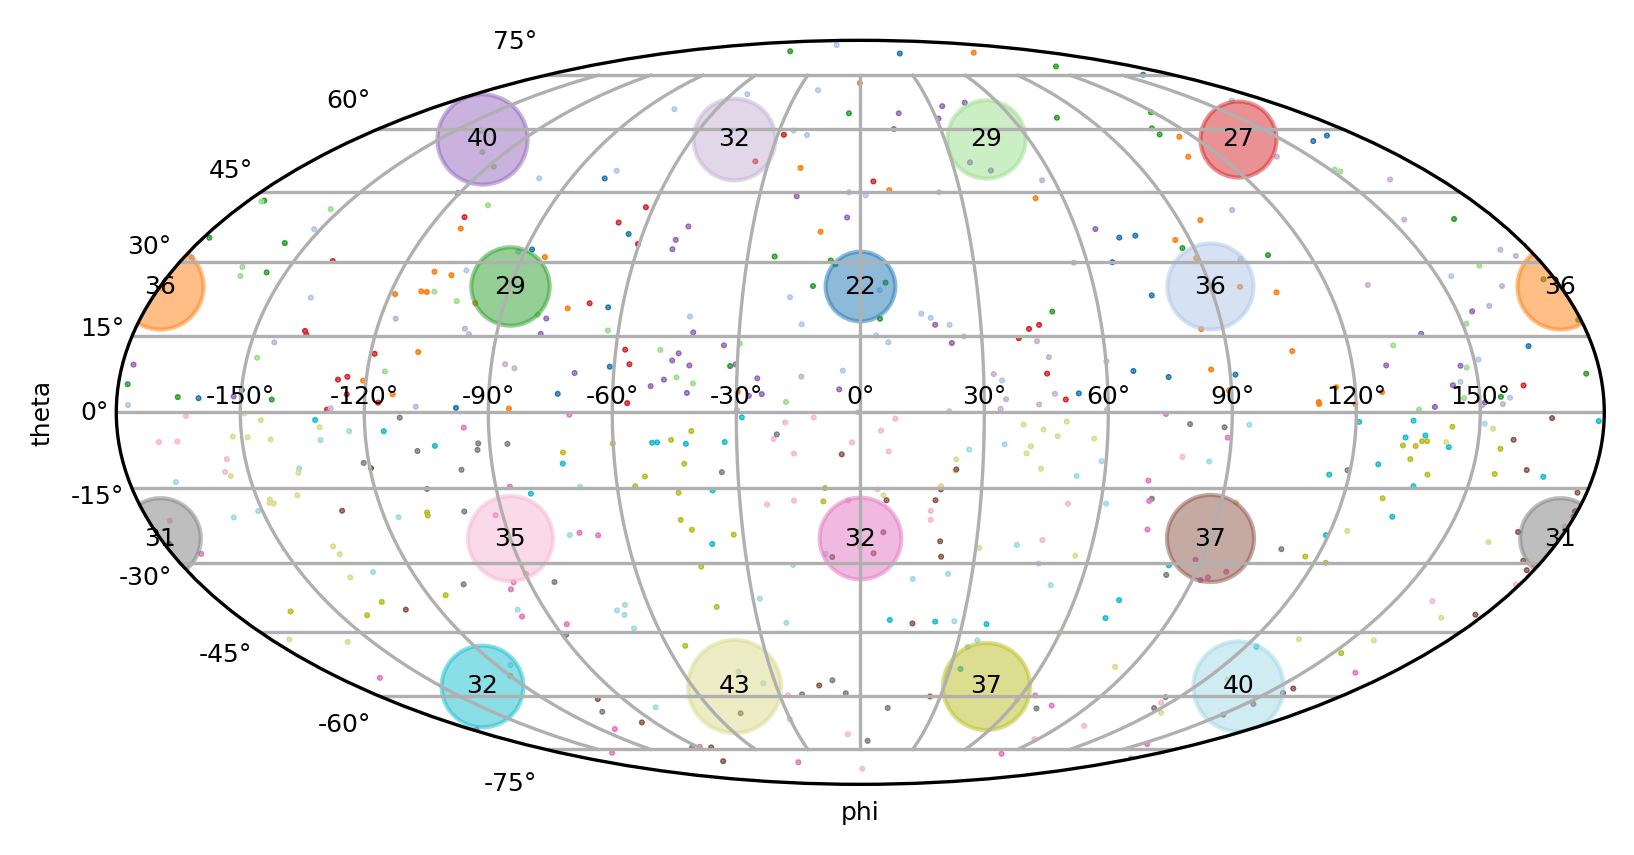

In [17]:
plot_sphere_projection(df_c)

these seem to pe purely "caotic" photons beeing randomly scatterd in the module

In [18]:
event_recreation(df_c, samples = 10)

            in_E      in_x       in_y      in_z     in_px     in_py     in_pz
903716   2.96876  141.5740 -252.18800  -79.7371 -0.273541  0.934403 -0.228182
758449   3.09295 -207.7030  -32.45750 -214.0230  0.681826  0.604563  0.411846
950485   2.73744  253.5660   51.46620 -151.8400 -0.956714  0.227784  0.181141
637330   3.45052  247.2960   47.58540 -163.0350 -0.998861 -0.046247 -0.011733
602017   3.55902  -62.2797 -103.83500 -274.4810  0.592857  0.608883  0.527050
393823   3.21858  279.4700   95.16730  -53.2915 -0.977036  0.003172 -0.213048
915456   2.88106 -295.4620  -17.04820  -49.1062  0.909465 -0.374007 -0.181638
1599768  2.81320  -71.6723 -290.26000   24.7468  0.467386  0.844910  0.260149
592419   3.40148 -255.4030   53.95800 -147.8430  0.813482 -0.576882 -0.073852
258046   3.03447  -77.5358   -1.25655 -289.8040  0.696831  0.047129  0.715685


Confirmed by Geant4:

In [19]:
images = ['c_1.png']
heights = [350]
html_str = ''
for img, height in zip(images, heights):
    html_str += f'<img src={img} height="{height}" />'
display(HTML(html_str))

### distribution between clusters

We now want to see how many photons we can expect to behave in those ways. we simply take the size of the clusters for that:

In [20]:
print(f"total ptotons detected:\t{len(df)}")
print(f"photons in cluster a:\t{len(df_a)}\t{round(len(df_a) / len(df) * 100 , 2)} %")
print(f"photons in cluster b:\t{len(df_b)}\t{round(len(df_b) / len(df) * 100 , 2)} %")
print(f"photons in cluster c:\t{len(df_c)}\t{round(len(df_c) / len(df) * 100 , 2)} %")

total ptotons detected:	117316
photons in cluster a:	8920	7.6 %
photons in cluster b:	1003	0.85 %
photons in cluster c:	538	0.46 %
